In [1]:
import os
import copy

import numpy as np

from nems import Model, visualization

In [2]:
# load data (download if necessary)
signals_dir = "/auto/data/nems_db/recordings"
basename = 'TAR010c-18-2.npz'
datafile = os.path.join(signals_dir, basename)

if not os.path.exists(datafile):
    print(f"Need to download demo data file {datafile}")
    import requests
    prefix = 'https://s3-us-west-2.amazonaws.com/nemspublic/sample_data/'
    uri = prefix + basename
    r = requests.get(uri, stream=True)
    with open(datafile, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    
d = np.load(datafile)

cellid = 'TAR010c-18-2'
fs = 100
X_est=d['X_est']
Y_est=d['Y_est']
X_val=d['X_val']
Y_val=d['Y_val']

In [3]:
# normalize stimulus peak to 1
X_norm = X_est.max()
X_est /= X_norm
X_val /= X_norm

In [4]:
modelspec = 'wc.18x1-fir.15x1-relu.1.o.s'
modelspec = 'wc.18x2-fir.15x2-dexp.1'
model0 = Model.from_keywords(modelspec)
model0.sample_from_priors();

## Scipy backend fit

In [5]:
model_sci = copy.deepcopy(model0)

print('Backend: scipy, Fitting without NL ...')
model_sci.layers[-1].skip_nonlinearity()
fitter_options={'cost_function': 'nmse', 'options': {'ftol': 1e-5, 'maxiter': 100}}
model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options=fitter_options)

print('Backend: scipy, Now fitting with NL ...')
model_sci.layers[-1].unskip_nonlinearity()
fitter_options['options']['ftol'] = 1e-6

model_sci=model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options=fitter_options)

Backend: scipy, Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00297111...
        Iteration 5, error is: 0.98405254...
        Iteration 10, error is: 0.94478754...
        Iteration 15, error is: 0.91869088...
        Iteration 20, error is: 0.91195483...
        Iteration 25, error is: 0.90757063...
        Iteration 30, error is: 0.90633807...
        Iteration 35, error is: 0.90599271...
        Iteration 40, error is: 0.90567305...
        Iteration 45, error is: 0.90547887...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Backend: scipy, Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 0.89734182...
        Iteration 5, error is: 0.88564702...
        Iteration 10, error is: 0.88180929...
        Iteration 15, error is: 0.87707011...
        Iteration 20, error is: 0.87582863...
        Iteration 25, error is: 0.87517524...
        Iteration 30, error is: 0.87448648...
        Iteration 35, error is: 0.87398

prediction correlation: 0.606


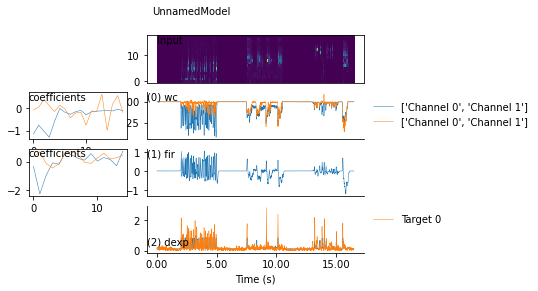

In [6]:
prediction = model_sci.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_sci, X_val, target=Y_val, sampling_rate=fs);

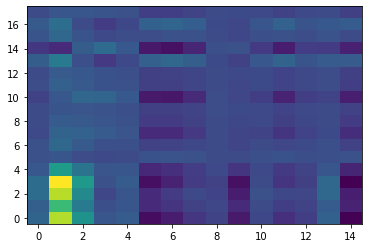

In [7]:
visualization.model.simple_strf(model_sci);

## TF backend fit

In [5]:
model_tf = copy.deepcopy(model0)

fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 150,
                  'early_stopping_tolerance': 5e-4, 'validation_split': 0.0, 
                  'learning_rate': 5e-3, 'epochs': 2000}

print('Backend: tf, Fitting without NL ...')
model_tf.layers[-1].skip_nonlinearity()
model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

print('Backend: tf, Now fitting with NL ...')
model_tf.layers[-1].unskip_nonlinearity()
fitter_options['learning_rate'] = 1e-4
fitter_options['early_stopping_tolerance'] = 1e-5

model_tf=model_tf.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options, batch_size=None)

Backend: tf, Fitting without NL ...


2022-08-27 13:35:45.999729: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-27 13:35:46.638311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6786 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1


1 Physical GPUs, 1 Logical GPUs
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 49500, 18)]       0         
                                                                 
 wc (WeightChannelsTF)       (None, 49500, 2)          36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 49500, 1)         30        
 F)                                                              
                                                                 
 dexp (StaticNonlinearityTF)  (None, 49500, 1)         4         
                                                                 
Total params: 70
Trainable params: 67
Non-trainable params: 3
_________________________________________________________________
None
<function loss_tf_nmse at 0x7f83f9386b80>


2022-08-27 13:35:47.497429: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-08-27 13:35:47.499775: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 13:35:47.502145: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch 1/2000
1/1 [==============================] - 1s 558ms/step - loss: 0.9557
Epoch 2/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9506
Epoch 3/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9455
Epoch 4/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9402
Epoch 5/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9348
Epoch 6/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9292
Epoch 7/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9234
Epoch 8/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9175
Epoch 9/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9115
Epoch 10/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.9055
Epoch 11/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8994
Epoch 12/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8935
Epoch 13/2000
1/1 [============================

1/1 [==============================] - 0s 7ms/step - loss: 0.8102
Epoch 104/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8100
Epoch 105/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8098
Epoch 106/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8097
Epoch 107/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8095
Epoch 108/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8093
Epoch 109/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8091
Epoch 110/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8090
Epoch 111/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8088
Epoch 112/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8086
Epoch 113/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8085
Epoch 114/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8083
Epoch 115/2000
1/1 [====================

1/1 [==============================] - 0s 7ms/step - loss: 0.8036
Epoch 205/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8036
Epoch 206/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8036
Epoch 207/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8035
Epoch 208/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8035
Epoch 209/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8035
Epoch 210/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8035
Epoch 211/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8034
Epoch 212/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8034
Epoch 213/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8034
Epoch 214/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8034
Epoch 215/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8034
Epoch 216/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8022
Epoch 306/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8022
Epoch 307/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8022
Epoch 308/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8022
Epoch 309/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8022
Epoch 310/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8022
Epoch 311/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8022
Epoch 312/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8022
Epoch 313/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.8022
Epoch 314/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8022
Epoch 315/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8022
Epoch 316/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8021
Epoch 317/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 407/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 408/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 409/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 410/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 411/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 412/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 413/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 414/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 415/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 416/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 417/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8017
Epoch 418/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 508/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 509/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 510/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 511/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 512/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 513/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 514/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 515/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 516/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 517/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 518/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8014
Epoch 519/2000
1/1 [=======================

1/1 [==============================] - 0s 7ms/step - loss: 0.8011
Epoch 609/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8011
Epoch 610/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8011
Epoch 611/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8011
Epoch 612/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8011
Epoch 613/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8011
Epoch 614/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8011
Epoch 615/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.8011
Epoch 616/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8011
Epoch 617/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8011
Epoch 618/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8011
Epoch 619/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.8011
Epoch 620/2000
1/1 [=======================

Epoch 25/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7959
Epoch 26/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7958
Epoch 27/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7958
Epoch 28/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7957
Epoch 29/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7957
Epoch 30/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7957
Epoch 31/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7956
Epoch 32/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7956
Epoch 33/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7956
Epoch 34/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7955
Epoch 35/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7955
Epoch 36/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7955
Epoch 37/2000
1/1 [=====================

1/1 [==============================] - 0s 11ms/step - loss: 0.7938
Epoch 127/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7938
Epoch 128/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7938
Epoch 129/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7937
Epoch 130/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7937
Epoch 131/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7937
Epoch 132/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7937
Epoch 133/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7937
Epoch 134/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7937
Epoch 135/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7937
Epoch 136/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7937
Epoch 137/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7937
Epoch 138/2000
1/1 [=============

1/1 [==============================] - 0s 8ms/step - loss: 0.7931
Epoch 227/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7930
Epoch 228/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7930
Epoch 229/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7930
Epoch 230/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7930
Epoch 231/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7930
Epoch 232/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7930
Epoch 233/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7930
Epoch 234/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7930
Epoch 235/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7930
Epoch 236/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7930
Epoch 237/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7930
Epoch 238/2000
1/1 [===================

1/1 [==============================] - 0s 10ms/step - loss: 0.7926
Epoch 327/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7926
Epoch 328/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7926
Epoch 329/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7926
Epoch 330/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7926
Epoch 331/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7926
Epoch 332/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7926
Epoch 333/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7926
Epoch 334/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7926
Epoch 335/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7926
Epoch 336/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7926
Epoch 337/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7926
Epoch 338/2000
1/1 [====================

1/1 [==============================] - 0s 8ms/step - loss: 0.7923
Epoch 428/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7923
Epoch 429/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7923
Epoch 430/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7923
Epoch 431/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7923
Epoch 432/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7923
Epoch 433/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7923
Epoch 434/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7923
Epoch 435/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7923
Epoch 436/2000
1/1 [==============================] - 0s 6ms/step - loss: 0.7923
Epoch 437/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7923
Epoch 438/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7923
Epoch 439/2000
1/1 [=======================

1/1 [==============================] - 0s 8ms/step - loss: 0.7921
Epoch 529/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7921
Epoch 530/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7921
Epoch 531/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7921
Epoch 532/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7921
Epoch 533/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7920
Epoch 534/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7920
Epoch 535/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7920
Epoch 536/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7920
Epoch 537/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7920
Epoch 538/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7920
Epoch 539/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7920
Epoch 540/2000
1/1 [======================

1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 630/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7918
Epoch 631/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 632/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 633/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 634/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 635/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7918
Epoch 636/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 637/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 638/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 639/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7918
Epoch 640/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7918
Epoch 641/2000
1/1 [====================

1/1 [==============================] - 0s 10ms/step - loss: 0.7916
Epoch 731/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 732/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 733/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 734/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 735/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7916
Epoch 736/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 737/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 738/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 739/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7916
Epoch 740/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7916
Epoch 741/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7916
Epoch 742/2000
1/1 [====================

1/1 [==============================] - 0s 7ms/step - loss: 0.7914
Epoch 832/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7914
Epoch 833/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7914
Epoch 834/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7913
Epoch 835/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7913
Epoch 836/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7913
Epoch 837/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7913
Epoch 838/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7913
Epoch 839/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7913
Epoch 840/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7913
Epoch 841/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7913
Epoch 842/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7913
Epoch 843/2000
1/1 [=====================

1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 933/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 934/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7911
Epoch 935/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 936/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 937/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7911
Epoch 938/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7911
Epoch 939/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 940/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 941/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 942/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7911
Epoch 943/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7911
Epoch 944/2000
1/1 [=====================

1/1 [==============================] - 0s 7ms/step - loss: 0.7908
Epoch 1033/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7908
Epoch 1034/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7908
Epoch 1035/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7908
Epoch 1036/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7908
Epoch 1037/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7908
Epoch 1038/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7908
Epoch 1039/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7908
Epoch 1040/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7908
Epoch 1041/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7908
Epoch 1042/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7908
Epoch 1043/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7908
Epoch 1044/2000
1/1 [========

1/1 [==============================] - 0s 7ms/step - loss: 0.7905
Epoch 1132/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7905
Epoch 1133/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7905
Epoch 1134/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7905
Epoch 1135/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7905
Epoch 1136/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7905
Epoch 1137/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7905
Epoch 1138/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7905
Epoch 1139/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7905
Epoch 1140/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7905
Epoch 1141/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7905
Epoch 1142/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7905
Epoch 1143/2000
1/1 [=========

1/1 [==============================] - 0s 11ms/step - loss: 0.7902
Epoch 1231/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7902
Epoch 1232/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7902
Epoch 1233/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7902
Epoch 1234/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7902
Epoch 1235/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7902
Epoch 1236/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7902
Epoch 1237/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7902
Epoch 1238/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7902
Epoch 1239/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7902
Epoch 1240/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7902
Epoch 1241/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7902
Epoch 1242/2000
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 0.7898
Epoch 1330/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7898
Epoch 1331/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7898
Epoch 1332/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7898
Epoch 1333/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7898
Epoch 1334/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7898
Epoch 1335/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7898
Epoch 1336/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7898
Epoch 1337/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7898
Epoch 1338/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7898
Epoch 1339/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7898
Epoch 1340/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7898
Epoch 1341/2000
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 0.7894
Epoch 1429/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1430/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1431/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7894
Epoch 1432/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1433/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1434/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7894
Epoch 1435/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1436/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1437/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7894
Epoch 1438/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1439/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7894
Epoch 1440/2000
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 0.7889
Epoch 1528/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7889
Epoch 1529/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7889
Epoch 1530/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7889
Epoch 1531/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7889
Epoch 1532/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7889
Epoch 1533/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7889
Epoch 1534/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7889
Epoch 1535/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7889
Epoch 1536/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7889
Epoch 1537/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7889
Epoch 1538/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7889
Epoch 1539/2000
1/1 [======

1/1 [==============================] - 0s 8ms/step - loss: 0.7884
Epoch 1627/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7884
Epoch 1628/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7884
Epoch 1629/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7884
Epoch 1630/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7884
Epoch 1631/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7884
Epoch 1632/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7884
Epoch 1633/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7884
Epoch 1634/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7884
Epoch 1635/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7884
Epoch 1636/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7884
Epoch 1637/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7884
Epoch 1638/2000
1/1 [=====

1/1 [==============================] - 0s 10ms/step - loss: 0.7878
Epoch 1726/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7878
Epoch 1727/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7878
Epoch 1728/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7878
Epoch 1729/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7878
Epoch 1730/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7878
Epoch 1731/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7878
Epoch 1732/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7878
Epoch 1733/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7878
Epoch 1734/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7878
Epoch 1735/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7877
Epoch 1736/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7877
Epoch 1737/2000
1/1 [======

1/1 [==============================] - 0s 8ms/step - loss: 0.7871
Epoch 1825/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7871
Epoch 1826/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7871
Epoch 1827/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7871
Epoch 1828/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7871
Epoch 1829/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7871
Epoch 1830/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7871
Epoch 1831/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7871
Epoch 1832/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7871
Epoch 1833/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7871
Epoch 1834/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7871
Epoch 1835/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7871
Epoch 1836/2000
1/1 [=======

1/1 [==============================] - 0s 9ms/step - loss: 0.7864
Epoch 1924/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7864
Epoch 1925/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7864
Epoch 1926/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7864
Epoch 1927/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7863
Epoch 1928/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.7863
Epoch 1929/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7863
Epoch 1930/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7863
Epoch 1931/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.7863
Epoch 1932/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.7863
Epoch 1933/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.7863
Epoch 1934/2000
1/1 [==============================] - 0s 8ms/step - loss: 0.7863
Epoch 1935/2000
1/1 [======

prediction correlation: 0.554


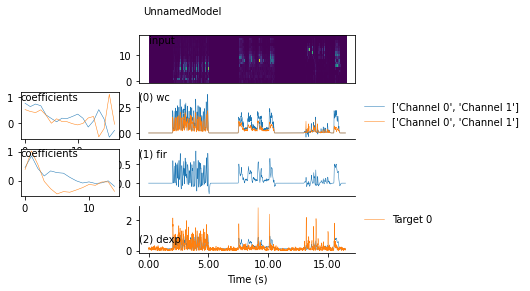

In [6]:
prediction = model_tf.predict(X_val)
cc = np.corrcoef(prediction[:,0], Y_val[:,0])[0,1]
print(f'prediction correlation: {cc:.3f}')
visualization.model.plot_model_with_parameters(
        model_tf, X_val, target=Y_val, sampling_rate=fs);

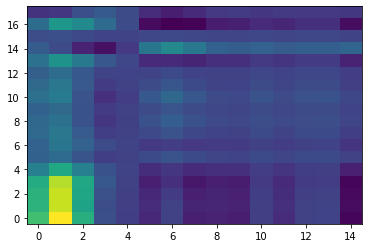

In [7]:
visualization.model.simple_strf(model_tf);

In [12]:
model_tf.layers[2].name

'dexp'